Jupyter notebook:
All credits go to: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

In [133]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
#import lightgbm as lgb

In [7]:
!ls data

Data_Dictionary.xlsx          sample_submission.csv
historical_transactions.csv   test.csv
merchants.csv                 train.csv
new_merchant_transactions.csv ~$Data_Dictionary.xlsx


In [8]:
train_df = pd.read_csv('data/train.csv', parse_dates=['first_active_month'])
test_df = pd.read_csv('data/test.csv', parse_dates=['first_active_month'])

In [9]:
print("Number of rows and columns in train: ", train_df.shape)
print("Number of rows and columns in test: ", test_df.shape)

Number of rows and columns in train:  (201917, 6)
Number of rows and columns in test:  (123623, 5)


In [10]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


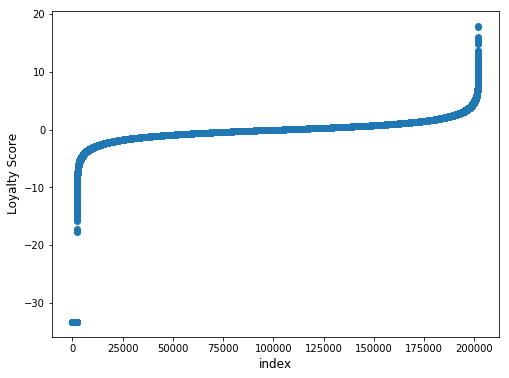

In [15]:
target_col = "target"

plt.figure(figsize={8,6})
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize = 12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

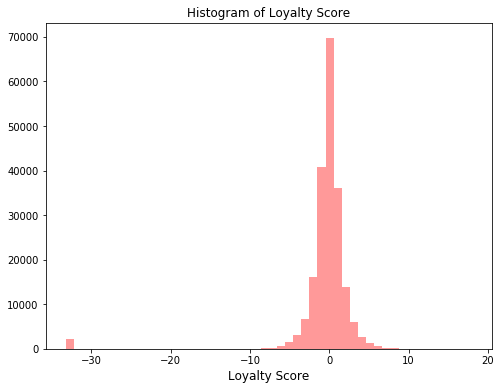

In [18]:
plt.figure(figsize={8,6})
sns.distplot(train_df[target_col].values, bins=50, color="red", kde=False)
plt.title("Histogram of Loyalty Score")
plt.xlabel('Loyalty Score', fontsize=12)
plt.show()

In [28]:
(train_df[target_col]<-30).sum()

2207

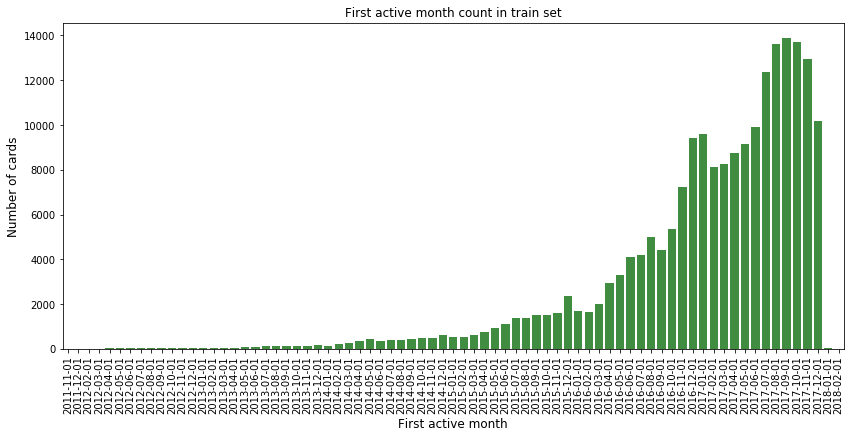

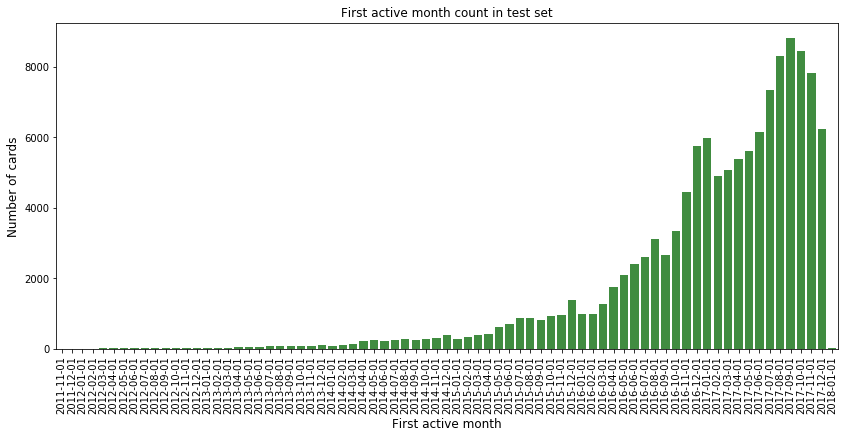

In [29]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

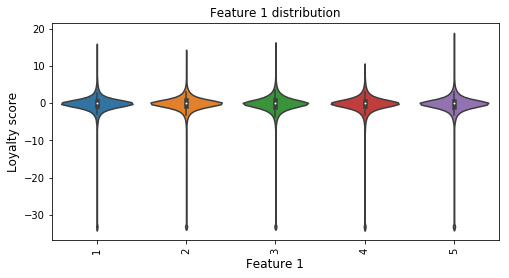

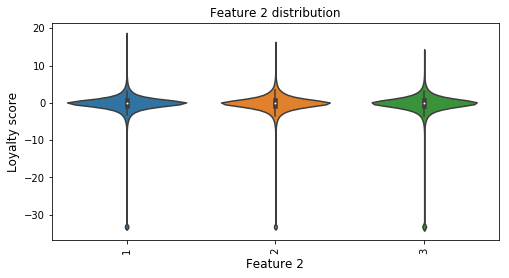

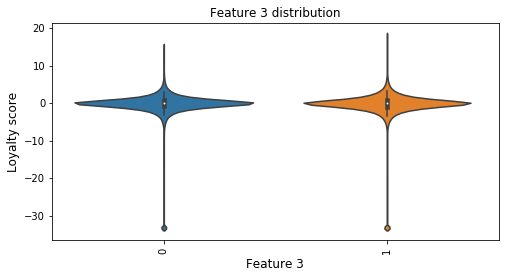

In [31]:
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

# Historical Transactions

In [37]:
hist_df = pd.read_csv('data/historical_transactions.csv')

In [38]:
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [39]:
hist_df.shape

(29112361, 14)

In [66]:
gdf = hist_df.groupby(['card_id'])

In [67]:
gdf = gdf['purchase_amount'].size().reset_index()

In [68]:
gdf.head()

,card_id,purchase_amount
0,C_ID_00007093c1,149
1,C_ID_0001238066,123
2,C_ID_0001506ef0,66
3,C_ID_0001793786,216
4,C_ID_000183fdda,144


In [69]:
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [82]:
cnt_srs = train_df.groupby("num_hist_transactions")[target_col].mean()

In [83]:
cnt_srs = cnt_srs.sort_index()

In [84]:
cnt_srs

num_hist_transactions
2      -0.303020
3       0.140517
4       0.168964
5       0.225922
6       0.121381
7       0.024721
8      -0.037409
9      -0.114815
10     -0.032045
11     -0.321186
12     -0.105167
13     -0.200472
14     -0.245999
15     -0.222139
16     -0.220756
17     -0.264405
18     -0.239402
19     -0.232557
20     -0.346304
21     -0.312765
22     -0.282003
23     -0.259389
24     -0.381846
25     -0.291186
26     -0.189261
27     -0.418503
28     -0.248114
29     -0.505096
30     -0.361940
31     -0.454701
          ...   
1252    0.408010
1253    0.129052
1256    1.093491
1257   -0.379098
1285    1.142620
1300   -0.336271
1313    0.376785
1317   -0.503539
1318   -1.571394
1323   -1.824637
1344   -0.402335
1350   -0.418470
1370   -0.617209
1389   -0.754208
1390    0.963957
1401   -1.317911
1414   -0.839651
1441    0.130068
1450   -0.801590
1462    0.001102
1546    2.679023
1550   -0.002145
1593   -0.641325
1634   -2.629027
1647   -0.236357
1665    0.278900
1786    4

In [85]:
cnt_srs = cnt_srs[:-50]

In [87]:
cnt_srs.index[::-1]

Int64Index([1118, 1113, 1112, 1109, 1107, 1104, 1103, 1101, 1099, 1097,
            ...
              11,   10,    9,    8,    7,    6,    5,    4,    3,    2],
           dtype='int64', name='num_hist_transactions', length=973)

In [90]:
def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Histtranscnt")

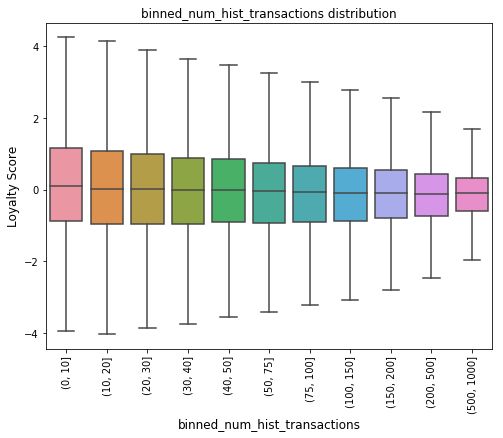

In [91]:
bins = [0,10,20,30,40,50,75,100,150,200,500,1000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(8,6))
sns.boxplot(x="binned_num_hist_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('binned_num_hist_transactions distribution')
plt.show()

In [92]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

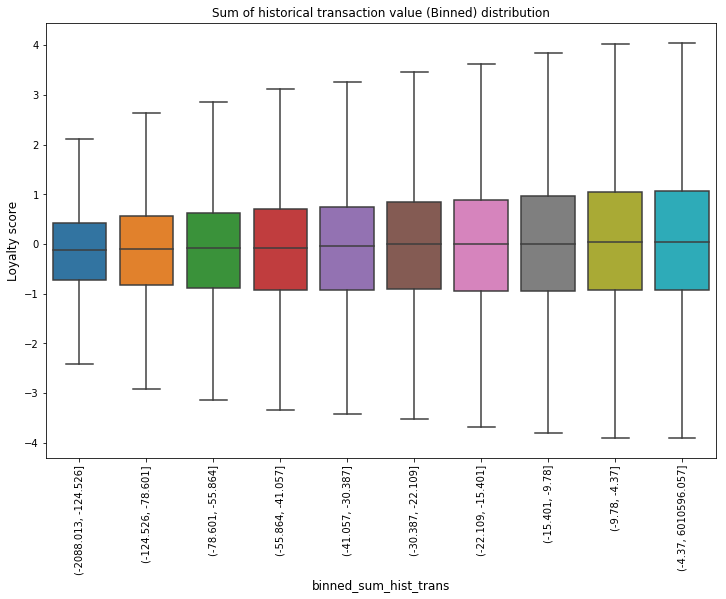

In [93]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

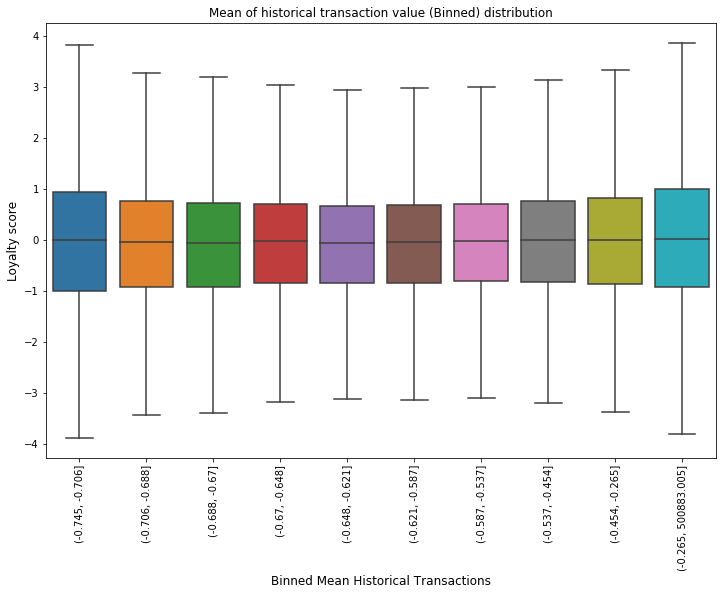

In [94]:
bins = np.percentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_mean_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

# New Merchant Transactions

In [96]:
new_trans_df = pd.read_csv('data/new_merchant_transactions.csv')

In [97]:
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [106]:
gdf = new_trans_df.groupby(['card_id'])
gdf = gdf['purchase_amount'].size().reset_index()
gdf.columns = ['card_id', 'num_merch_transactions']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

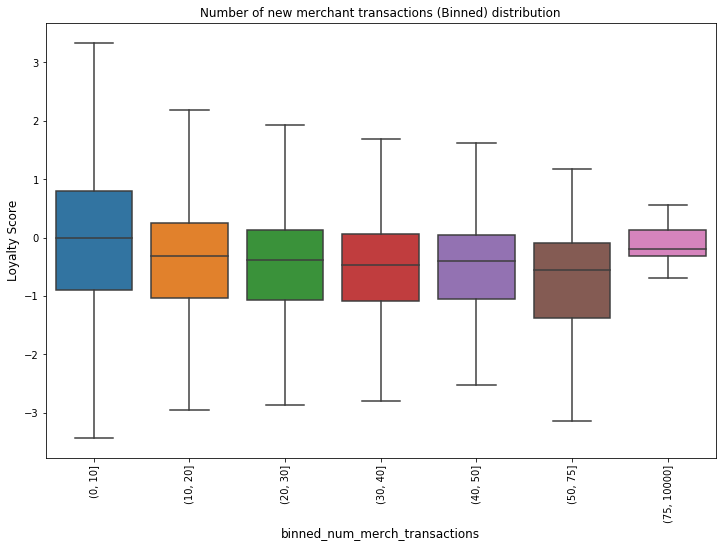

In [107]:
bins = [0,10,20,30,40,50,75,10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
cnt_srs = train_df.groupby('binned_num_merch_transactions')[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel("Loyalty Score", fontsize=12)
plt.title("Number of new merchant transactions (Binned) distribution")
plt.show()

In [108]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf['purchase_amount'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns =['card_id', 'sum_merch_trans', 'mean_merch_trans','std_merch_trans', 'min_merch_trans', 'max_merch_trans']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

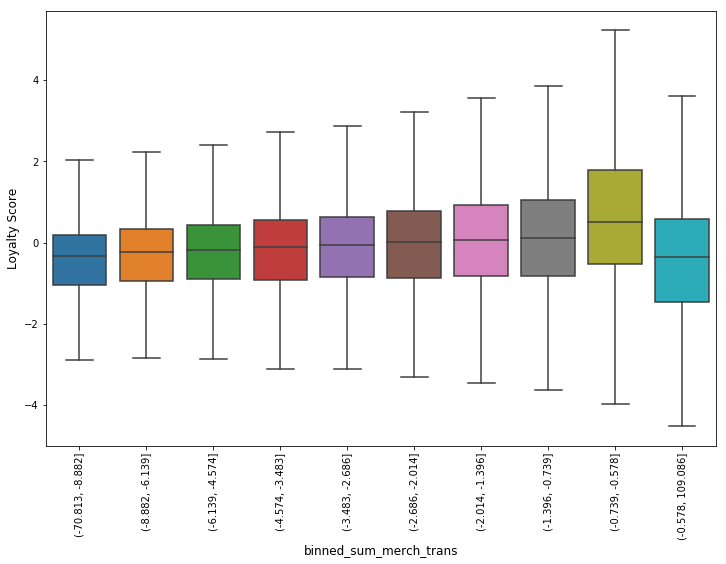

In [109]:
bins = np.nanpercentile(train_df['sum_merch_trans'], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel("binned_sum_merch_trans", fontsize=12)
plt.ylabel("Loyalty Score", fontsize=12)
plt.show()

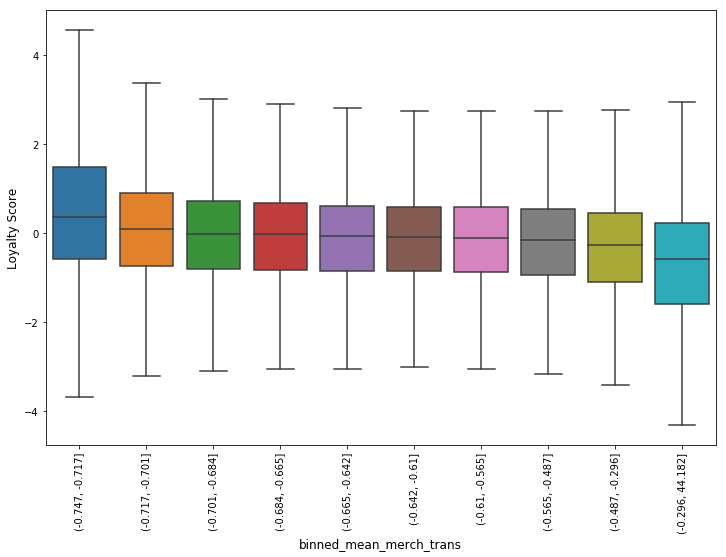

In [111]:
bins = np.nanpercentile(train_df['mean_merch_trans'], range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'], bins)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel("binned_mean_merch_trans", fontsize=12)
plt.ylabel("Loyalty Score", fontsize=12)
plt.show()

# Baseline Model

In [116]:
train_df['year'] = train_df['first_active_month'].dt.year
train_df['month'] = train_df['first_active_month'].dt.month
test_df['year'] = test_df['first_active_month'].dt.year
test_df['month'] = test_df['first_active_month'].dt.month

In [117]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,...,num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans,binned_sum_merch_trans,binned_mean_merch_trans,year,month
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,...,23.0,-13.244202,-0.575835,0.135812,-0.724368,-0.296112,"(-70.813, -8.882]","(-0.61, -0.565]",2017,6
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,...,6.0,-4.355735,-0.725956,0.014326,-0.739410,-0.701858,"(-4.574, -3.483]","(-0.747, -0.717]",2017,1
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,...,1.0,-0.700326,-0.700326,NaN,-0.700326,-0.700326,"(-0.739, -0.578]","(-0.701, -0.684]",2016,8
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,...,7.0,-4.654372,-0.664910,0.065882,-0.734135,-0.566740,"(-6.139, -4.574]","(-0.665, -0.642]",2017,9
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 150]",-48.687656,-0.366073,...,36.0,-19.926237,-0.553507,0.223821,-0.739395,0.450886,"(-70.813, -8.882]","(-0.565, -0.487]",2017,11


In [129]:
train_df.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'num_hist_transactions', 'binned_num_hist_transactions',
       'sum_hist_trans', 'mean_hist_trans', 'std_hist_trans', 'min_hist_trans',
       'max_hist_trans', 'binned_sum_hist_trans', 'binned_mean_hist_trans',
       'num_merch_transactions_x', 'binned_num_merch_transactions',
       'num_merch_transactions_y', 'num_merch_transactions', 'sum_merch_trans',
       'mean_merch_trans', 'std_merch_trans', 'min_merch_trans',
       'max_merch_trans', 'binned_sum_merch_trans', 'binned_mean_merch_trans',
       'year', 'month'],
      dtype='object')

In [130]:
test_df.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'num_hist_transactions', 'sum_hist_trans', 'mean_hist_trans',
       'std_hist_trans', 'min_hist_trans', 'max_hist_trans',
       'num_merch_transactions_x', 'num_merch_transactions_y',
       'num_merch_transactions', 'sum_merch_trans', 'mean_merch_trans',
       'std_merch_trans', 'min_merch_trans', 'max_merch_trans', 'year',
       'month'],
      dtype='object')

In [131]:
train_df.to_csv('data/processed_train.csv', index = False, index_label=False)

In [132]:
test_df.to_csv('data/processed_test.csv', index=False, index_label=False)